# Working with Data in Pandas

When we are working with data, it can be extremely useful to have arrays that are "smart", so they have information on which columns are which data channels, or perhaps index by a date. It's also really nice to have powerful data selection with little coding. Pandas is a fairly new package that accomplishes that.

## Further Resources

There are many available resources for tutorials with pandas. Here is just a few:  
- [DTU Wind Energy Toolbox](https://gitlab.windenergy.dtu.dk/toolbox/WindEnergyToolbox/blob/master/docs/using-statistics-df.md)  
- [Pandas cookbook](https://pandas.pydata.org/pandas-docs/stable/tutorials.html)  
- [Dataquest blog](https://www.dataquest.io/blog/pandas-python-tutorial/)  
- [Google](https://www.google.dk/search?q=pandas+tutorials) 
- (etc.)

## Preliminaries

This tutorial will be loading data from `risoe_demo_data.csv` (located in the repository). I generated the data in the `.csv` file by quering the Risø V52 met mast SQL database.

In case you want to query an SQL database yourself later:  
1. Get granted access to the database by the owner (you need a username/password)  
2. Use conda to install Python package `sqlalchemy` (see Workshop 1)  
3. Install `mysqlclient` using conda (Mac/Linux) or pip  
4. Use the code in the cell below to query the SQL database and load the results to pandas. Be sure to delete the "DEMO ONLY" lines (unless you want to save your queried data as a `.csv`).

In [ ]:
# host, port = 'ri-veadbs04', 3306  # this is the host and port I was told for the Risø V52 met mast SQL database
# dbname = 'v52mast_risoe.calmeans'  # this is the database name for the mean values of the met mast
# username, password = ADD_ME, ADD_ME  # here is where you add strings of your username and password
# db_path = 'risoe_demo_data.csv'  # name of the csv I created for this demo. (DEMO ONLY)
# n_load = 500  # how many values to load for the demo
#
# query = f'select * from {dbname} limit {n_load};'  # an SQL query (get n_load rows from the database)
# con_str = f'mysql+mysqldb://{username}:{password}@{host}:{port}'  # connection string for sqlalchemy
# engine = sqlalchemy.create_engine(con_str)  # create a conneciton engine in sqlalchemy
# with engine.connect() as conn:  # use what's called a "context manager" to make sure connection closes
#     df = pd.read_sql_query(query, conn)  # load the results from my query to a pandas dataframe
# df.to_csv(db_path, index=False)  # save the pandas dataframe to a csv file (DEMO ONLY)

As always, we must first import the modules we want to use before we can write any code. Iøm also setting the jupyter matploblib option to be interactive, as we can do in notebooks.

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd

## Loading Data using Pandas

If we have a `.csv`, pandas can immediately load it. If you have a file that's delimited by whitespace, you can use the option `delim_whitespace=True` to parse it properly. Our file is separated by commas, however, so there's no need to use that option.

In [ ]:
means_path = 'data/demo_risoe_data_means.csv'  # define the path to our csv file
means_df = pd.read_csv(means_path)  # read the CSV to a pandas dataframe
stdvs_path = 'data/demo_risoe_data_stdvs.csv'
stdvs_df = pd.read_csv(stdvs_path)

Note that `read_csv()` is a function that is defined in the pandas module. We imported pandas as `pd`, then we used the dot operator to access the function defined in the module.

The `read_csv()` function has now loaded the `.csv` information into a pandas-specific object called a [DataFrame](https://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe). This object comes with many useful attributes (things associated with the object) and methods (functions associated with the object) that are listed [here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html).

## Indexes and Columns

For now, let's focus on the dataframe with the mean values. We'll look into combining it with the std one a bit later.

The dataframe is essentially a 2D array. We can determine the shape of the underlying array using the `shape` attribute: 

In [ ]:
means_df.shape

We pulled 500 rows from the SQL database, so that makes sense. We have 65 columns. Let's see what those are, eh?

The beauty of dataframes is that the rows and columns are labeled with an "index" and a column identifier, respectively. We can access the index and list of columns using the following commands:

In [ ]:
print(means_df.index)
print(means_df.columns.values)  # add '.values' to "prettify" output

So, our current index is just a "range" (i.e., a set of integers) from 0 to 499, and we have a lot of columns. Let's glimpse our dataframe.

In [ ]:
means_df.head()  # take a look at the first few rows

How cool! And jupyter prints things so nicely. 

We can also get a statistical glimpse at the dataframe using `describe()`:

In [ ]:
means_df.describe()

That's pretty cool. All the information is lined up nicely.

**BUT** now that we are looking at it, our index should probably be `name`. (After all, that's a unique identifier for each row.) And, while we're at it, let's change `name` from an integer to a datetime datatype. (This is not only [really powerful](https://pandas.pydata.org/pandas-docs/stable/timeseries.html), it will also be useful later.) The string format specifiers can be found [here](https://docs.python.org/2/library/datetime.html#strftime-and-strptime-behavior).

In [ ]:
means_df['name'] = pd.to_datetime(means_df['name'].astype(str), format='%Y%m%d%H%M')  # convert name to datetime
means_df.set_index('name', inplace=True)  # set name as index (see cell below for notes)
means_df.head()  # preview new dataframe

Sweet! Now our index is a datetime that makes sense.

A few notes on `set_index()`:  
- By default, it will not change the original dataframe but will return a new dataframe. We actually want to change the original, though, so we use `inplace=True`.  
- By default, it will delete the column once the new index has been defined. If you don't want this for some reason, use `drop=False`.

Let's quickly do the same for the dataframe with the standard deviations.

In [ ]:
stdvs_df['name'] = pd.to_datetime(stdvs_df['name'].astype(str), format='%Y%m%d%H%M')  # convert name to datetime
stdvs_df.set_index('name', inplace=True)

Hm...it's annoying that we have two different dataframes. Could we combine them?

## Merging Dataframes

If two dataframes have the same index (e.g., a date), then we can merge them into a single dataframe. This is really nice for slicing, as we'll see later.

First, we need to check that their indices match. If they don't, then merging will cause weird things.

In [ ]:
means_df.index.equals(stdvs_df.index)  # check whether one index equals the other

The indices match! Great.

Now, for merging. The webpage on merging is [here](https://pandas.pydata.org/pandas-docs/stable/merging.html). It's important that our column names of each dataframe don't match.

In [ ]:
means_df.columns.equals(stdvs_df.columns)  # check whether the columns match

Crap. They do. Well, let's fix it by appending `'_mean'` to the columns in `means_df` and `'_stdv'` to the columns in `stdvs_df`.

In [ ]:
means_df = means_df.add_suffix('_mean')  # append '_mean' to all columns
stdvs_df = stdvs_df.add_suffix('_stdv')  # append '_stdv' to all columns
print(means_df.columns[:2].values, stdvs_df.columns[:2].values)  # check our new columns

Cool. Now that the columns are different, but the indexes are the same, we can just use pandas `concat()` function.

In [ ]:
met_df = pd.concat([means_df, stdvs_df], axis=1)  # concatenating horizontally
print(means_df.shape, stdvs_df.shape, met_df.shape)
met_df.columns.values

EXCELLENT. Now that we have a dataframe with both the means and the standard deviation combined, let's look into how we can sub-select useful data.

## Slicing a Pandas Dataframe

There are generally two ways to slice a dataframe: by integers (i.e., classic array slicing) or by index/column labels. A detailed explanation of indexing is [here](https://pandas.pydata.org/pandas-docs/stable/indexing.html).

Let's explore both ways.

### Integer-Based Slicing

Integer slicing should look very familiar to you: this is very similary to NumPy array slicing. We perform integer slicing using the `iloc` attribute.

There are two categories within integer-based slicing to keep in your mind:  
1. Slicing and returning a dataframe  
2. Slicing and returning a pandas dataseries  

Let's start with returning a dataframe.

In [ ]:
slice_df = met_df.iloc[4:9, [0, 3, 7, 9]]  # rows 4 through 8 of a selection of 4 different columns
slice_df

Now, you can return a data series instead of a dataframe if you specify the column as a single integer. Note, in this case, that you will lose some of the dataframe-specific methods and attributes. For example:

In [ ]:
bad_slice = met_df.iloc[:, 0]  # bad_slice is actually a series, not a dataframe
print(type(bad_slice))
bad_slice.columns  # this dies! series don't have columns!

### Label-Based Slicing

Integer slicing can be really annoying in a lot of cases. After all, who wants to keep track of which column is a specific data channel? Ain't nobody got time for that.

That's where label-based slicing is king.

Just as with integer-based slicing, there are two categories within label-based slicing:  
1. Slicing and returning a dataframe  
2. Slicing and returning a data series

Let's tackle option 2 first.

In [ ]:
wsp_ds = met_df.Wsp_70m_mean  # you can access any underlying data series by using the dot operator
wsp_ds.head()  # the resulting ds still has its index, and a few of the same methods as the dataframe

Now, onto option 1. Let's show how powerful pandas is.

Let's say I want all the mean wind speed outputs at all heights for October 18, 2015. How can I do that?

In [ ]:
oct_day_slice = met_df.loc['2015-10-18', [s for s in met_df.columns if 'Wsp' in s and '_mean' in s]]  # BOOOOOOOOM
oct_day_slice.head()

Let's explain this in a bit more detail.

First, the date slicing. Pandas is *smart*. If you feed in a string that is 'YYYY', 'YYYY-MM', or 'YYYY-MM-DD', it will interpret what you probably mean. So, we've used this option to pull out all data from the 18th of October with this index:  

`'2015-10-18'`  

You could also specify a range of days (e.g., `'2015-10-18':'2015-10-20'`). Note that the last day will be included in the slice, unlike normal array indexing.

That's dang snazzy.

Now, I have also used list comprehension to get a list of columns with `Wsp` in the column with this line:  

`[s for s in met_df.columns if 'Wsp' in s]`  

Remember that, with list comprehension, the line above is just like the following for loop:  
```lc_list = []
for s in met_df.columns:
    if 'Wsp' in s:
        lc_list.append(s)
```

We can check that the output matches what we expect:

In [ ]:
print(f'First: {oct_day_slice.index[0]}, Last: {oct_day_slice.index[-1]}')  # first and last index items
print(oct_day_slice.columns.values)  # adding `.values` keeps it from outputting useful, though cluttering, metadata

## Selecting and Plotting Data Based on Dataframe Values

Pandas can also select sub-dataframes based on the values in the dataframe. For example, let's take all the data in October, filter it so that the $U_{70m}>2$ m/s and $\sigma_u> 0.2$, and do some quick analyses with it.

In [ ]:
oct_slice = met_df.loc['2015-10', :]  # all data in october
oct_slice = oct_slice.loc[(oct_slice.Wsp_70m_mean > 2) & (oct_slice.Wsp_70m_stdv > 0.2)]  # u > 2 and sig_u > 0.2

In the first line, we are using pandas's partial string slicing to get all the data in October. In the second line, we then take the October slice, and apply our desired filtering. Note that we've had to separate the partial-date slicing with the other filtering, because pandas unfortunately can't seem to handle them combined.

Now that we have our filtered, desired slice, let's make a few quick plots.

<IPython.core.display.Javascript object>


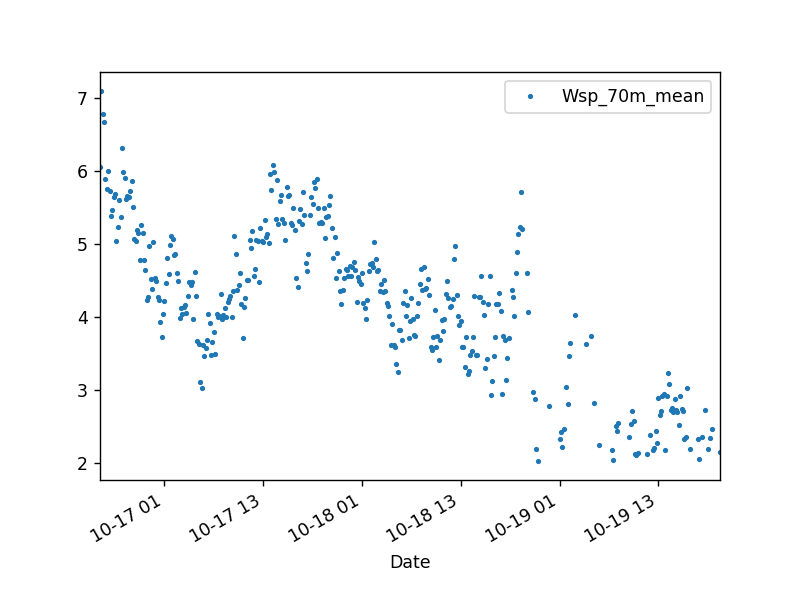

In [60]:
ax = oct_slice.plot(y='Wsp_70m_mean', linestyle='none', marker='o', markersize=2)  # plot mean wind speed over time
ax.set_xlabel('Date');  # suppress jupyter output

<IPython.core.display.Javascript object>


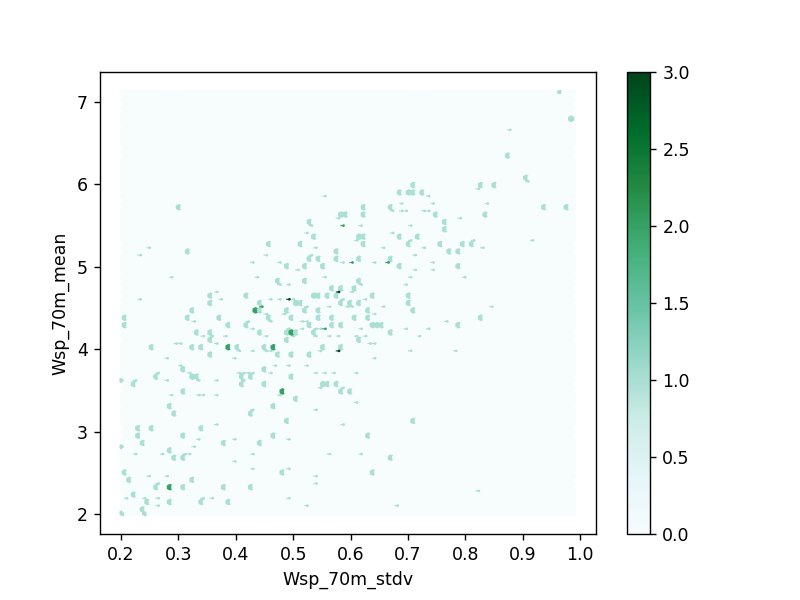

In [67]:
oct_slice.plot(x='Wsp_70m_stdv', y='Wsp_70m_mean', kind='hexbin');

<IPython.core.display.Javascript object>


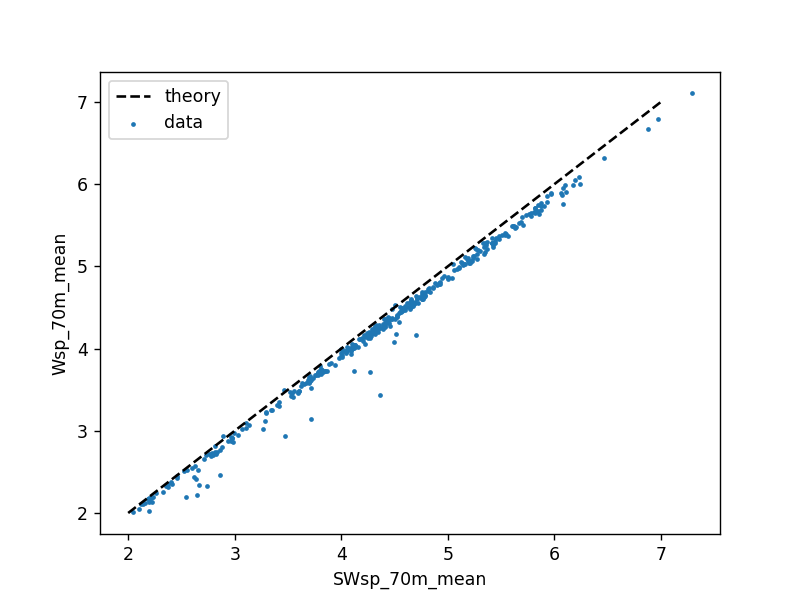

In [71]:
ax = oct_slice.plot(x='SWsp_70m_mean', y='Wsp_70m_mean', kind='scatter', s=3, label='data')
ax.plot([2, 7],[2, 7], 'k--', label='theory')
ax.legend();  # suppress jupyter output with ';'